In [1]:
# Vamos fazer fine-tuning com o modelo MobileNetV2, que é leve, eficiente e já vem com pesos pré-treinados no ImageNet.

In [2]:
# Import

In [1]:
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import time
import json

In [2]:
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, log_loss

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [4]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
#plt.rcParams["image.cmap"] = "gray"

In [5]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

| Parâmetro             | Valor                                                   |
| --------------------- | ------------------------------------------------------- |
| **Tamanho da imagem** | `224x224` (padrão do MobileNetV2)                       |
| **Número de canais**  | 3 (imagens RGB)                                         |
| **Tipo de dado**      | `float32`                                               |
| **Escala de pixel**   | Deve ser normalizada com `preprocess_input` (de -1 a 1) |


In [6]:
# Parâmetros
img_height, img_width = 224, 224
image_size = (img_width, img_height)
batch_size = 32
input_shape = (img_height, img_width, 3)

In [7]:
base_dir = './datasets/Plastic_Classification/'

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=image_size,
    batch_size=batch_size,  
    label_mode='categorical',  # ideal para softmax (MobileNetV2)
    shuffle=True,
    seed=42
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)




Found 1441 files belonging to 7 classes.
Found 416 files belonging to 7 classes.
Found 209 files belonging to 7 classes.


In [9]:
## Pré-processamento e normalização

MobileNetV2 espera as imagens normalizadas entre -1 e 1.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))


In [11]:
## Criar o modelo com MobileNetV2 (camadas congeladas + novas camadas finais):


In [12]:
import os

class_names = sorted(os.listdir(os.path.join(base_dir, 'train')))
num_classes = len(class_names)


# Base do modelo
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # congela pesos

# Nova cabeça do modelo
global_avg = tf.keras.layers.GlobalAveragePooling2D()
dropout = tf.keras.layers.Dropout(0.3)
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

# Modelo final
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = global_avg(x)
x = dropout(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs, outputs)



In [13]:
## Compilar o modelo

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
## Treinar com early stopping e callbacks

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('mobilenetv2_best_model.keras', save_best_only=True)
]
# Treinamento
start_time = time.time()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

end_time = time.time()
training_time = end_time - start_time
print(f"\n Tempo de treinamento: {training_time:.2f} segundos")


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.2775 - loss: 1.9563 - val_accuracy: 0.5793 - val_loss: 1.2686
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6655 - loss: 0.9475 - val_accuracy: 0.6611 - val_loss: 1.0494
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7582 - loss: 0.7354 - val_accuracy: 0.6923 - val_loss: 0.9571
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8005 - loss: 0.6106 - val_accuracy: 0.6995 - val_loss: 0.9026
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8287 - loss: 0.5318 - val_accuracy: 0.7236 - val_loss: 0.8687
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8379 - loss: 0.4942 - val_accuracy: 0.7332 - val_loss: 0.8242
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8444 - loss: 0.4560 - val_accuracy: 0.7428 - val_loss: 0.8219
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8879 - loss: 0.3873 - val_accuracy: 0.7596 - val_loss

In [17]:
# Avaliação
start_time = time.time()
loss, accuracy = model.evaluate(test_ds, verbose=1)
end_time = time.time()

print(f"Acurácia: {accuracy:.4f}")
print(f"Loss: {loss:.4f}")
print(f"Tempo de avaliação: {(end_time - start_time):.2f} segundos")

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.0688 - loss: 4.8390
Acurácia: 0.1340
Loss: 4.1678
Tempo de avaliação: 11.50 segundos


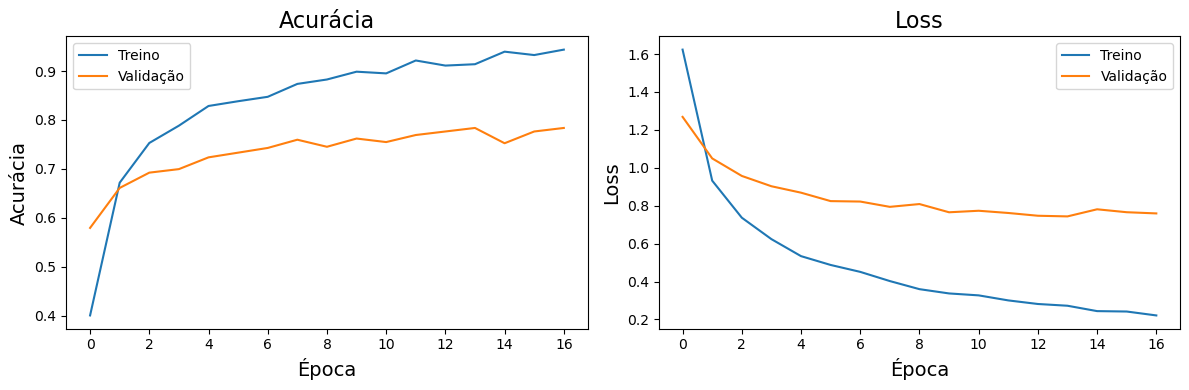

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Avaliar modelo no conjunto de teste

In [19]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report
import os

# Pegando os nomes das classes
class_names = sorted(os.listdir('./datasets/Plastic_Classification/test/'))

# Predição
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Rótulos verdadeiros
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_true = np.argmax(y_true, axis=1)

# Métricas
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
loss_val = log_loss(y_true, y_pred_probs)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names)

# Exibir resultados
print(f"Acurácia: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Log Loss: {loss_val:.4f}")
print("Matriz de Confusão:")
print(cm)
print("Relatório de Classificação:")
print(report)


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Acurácia: 0.1340
F1-score: 0.0685
Log Loss: 4.1678
Matriz de Confusão:
[[ 1  0  6  0  0  0 23]
 [ 0  0 18  0  0  1 11]
 [ 0  0  5  0  0  0 25]
 [ 0  0  9  0  0  0 20]
 [ 0  0  8  0  0  0 22]
 [ 0  0  6  0  0  1 23]
 [ 0  0  9  0  0  0 21]]
Relatório de Classificação:
              precision    recall  f1-score   support

        HDPE       1.00      0.03      0.06        30
        LDPA       0.00      0.00      0.00        30
       Other       0.08      0.17      0.11        30
         PET       0.00      0.00      0.00        29
          PP       0.00      0.00      0.00        30
          PS       0.50      0.03      0.06        30
         PVC       0.14      0.70      0.24        30

    accuracy                           0.13       209
   macro avg       0.25      0.13      0.07       209
weighted avg       0.25      0.13      0.07       209



C:\Users\graci.DESKTOP-I7T8UK6\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\graci.DESKTOP-I7T8UK6\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\graci.DESKTOP-I7T8UK6\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


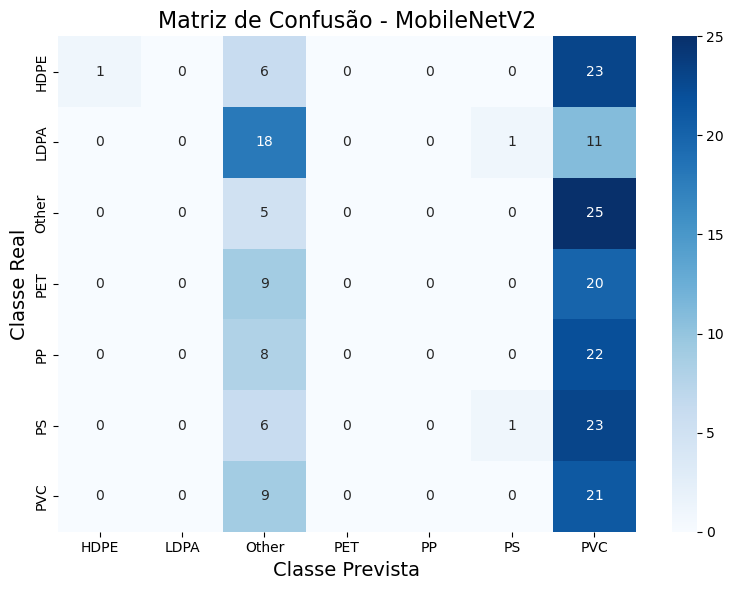

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matriz de confusão (caso ainda não tenha sido gerada)
cm = confusion_matrix(y_true, y_pred)

# Plot com seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Matriz de Confusão - MobileNetV2')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


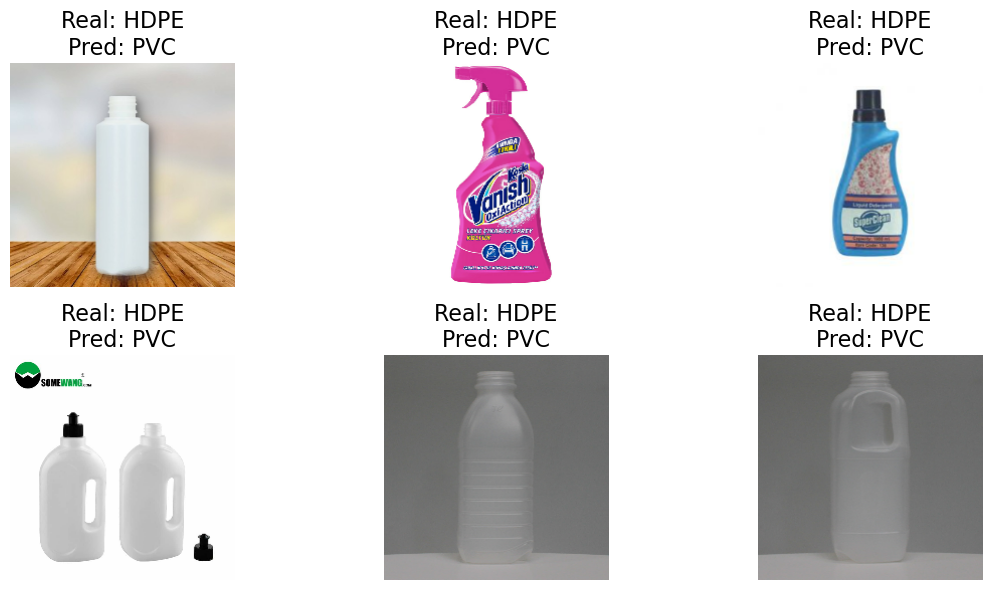

In [20]:
# Obter um lote do conjunto de teste
images, labels = next(iter(test_ds))
preds_probs = model.predict(images)
preds_classes = tf.argmax(preds_probs, axis=1)

plt.figure(figsize=(12, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    
    # Converter corretamente os labels para inteiros
    true_label = tf.argmax(labels[i]).numpy() if labels[i].ndim > 0 else labels[i].numpy()
    pred_label = preds_classes[i].numpy() if isinstance(preds_classes[i], tf.Tensor) else preds_classes[i]

    plt.title(f"Real: {class_names[true_label]}\nPred: {class_names[pred_label]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

